# Çöp Sınıflandırma Projesi

### Proje Amacı Nedir?
Kamera önüne otomatik bir banttan geldiği hayal edilen atıkların cam, plastik, metal gibi ayrışmalarını yaparak uygun kutulara dağıtan bir yapay zeka uygulaması. Sınıflandırma yapılması sonrasında arayüzden çöplerin üstüne hangi katagoriden olduğunun yazılması ve eşleşme oranlarının ifade edilmesi.

------

Projemize Başlayabiliriz. İlk olarak gerekli kütüphanelerin eklenmesi gerekmektedir. Ancak tensorflow'un yüklenmesi genellikle sancılı bir süreçtir bu nedenle en kolay olarak anacondadan tensorflow'u seçerek yükleyebiliriz. Sonrasında tensorflow içerisinden bazı paketlere metotlara kütüphane olarak eklememiz gerekmektedir (yani from x import y,z,b gibi) Eklememiz gereken kütüphaneler sırasıyla:

- Tensorflow'u tf olarak 
- Tensorflow'un keras paketini keras olarak 
- Tensforlow'un keras.callbacks paketi içerisinden ModelChechpoint kütüphanesi
- Tensforlow'un keras.layers paketi içinden Conv2D, Flatten, MaxPooling2D,Dense,Dropout kütüphaneleri
- Tensforlow'un keras.models paketi içerisinden Sequential Paketi
- Tensorflow'un keras.preprocessing.image paketi içerisinden ImageDataGenerator Paketi

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'tensorflow'

Daha sonrasında görüntüleri daha güzel bir şekilde göstermek için matplotlib içerisinden bazı paketlerin yüklenmesi gerekmektedir. Bu fonksiyon alt kısımda verilen fonksiyon ile gerçekleştirilebilir.

In [2]:
import matplotlib.pyplot as plt
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

Devamında "os" kütüphanesi import ile eklenmelidir. Kütüphane eklendikten sonra çalışıp çalışmadığını denemek için içerisinde bulunan 'listdir()' metotu ile verisetindeki veri gruplarının olduğu klasör isimleri ekrana yazdırılır.

In [17]:
import os
print(os.listdir('input/garbage-classification/garbage classification/Garbage classification'))

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


-------
Verilere erişmek için yukarda yazmış olmanız gereken kodda da görebileceğiniz gibi çok uzun veri yolu girmemiz gerekmektedir (input/garbage-classification/garbage classification/Garbage classification). Bu yolu her seferinde kodumuza eklemek yerine bir string değerine atayabiliriz.

In [37]:
veri_yolu = 'input/garbage-classification/garbage classification/Garbage classification'

Alt kısımda ifade edilidiği şekilde klasörlere erişip doğru yolu çalıştırıp çalıştırmadığımızı kontrol edebiliriz.

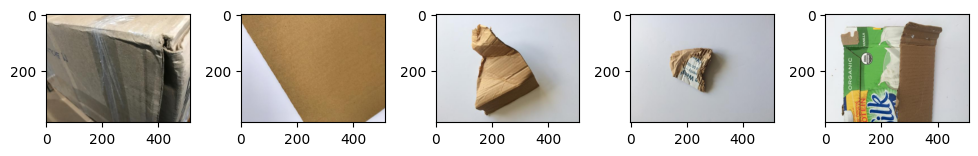

In [38]:
plot_imgs(veri_yolu+'/cardboard')


Aynı işlemi cam klasörü için yapmamız gerekmektedir.

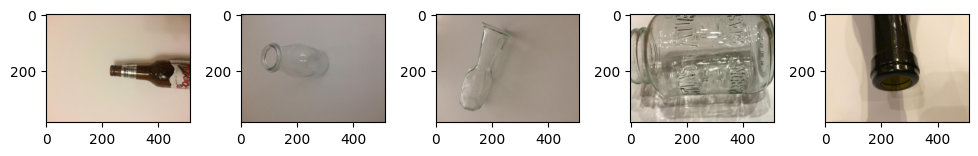

In [39]:
plot_imgs(veri_yolu+'/glass')


Aynı işlemi kağıt klasörü için de yapmamız gerekmektedir.

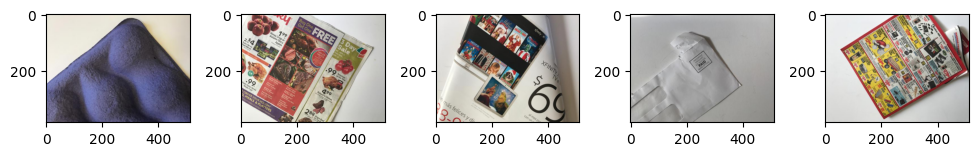

In [40]:
plot_imgs(veri_yolu+'/paper')


Aynı işlemi plastik klasörü için de yaparız

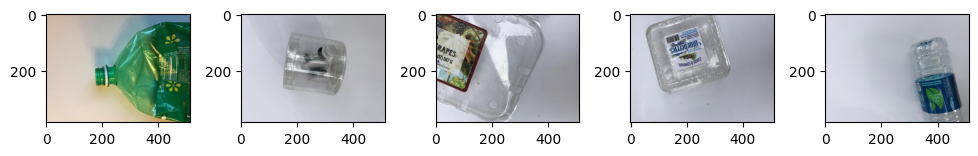

In [41]:
plot_imgs(veri_yolu+'/plastic')


Aynı işlemi Metal klasörü için de gerçekleştiririz

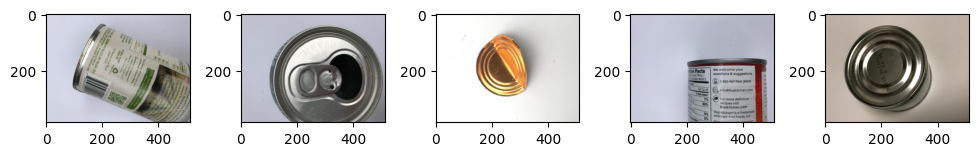

In [42]:
plot_imgs(veri_yolu+'/metal')


Aynı işlemi çöp klasörü için de gerçekleştiririz.

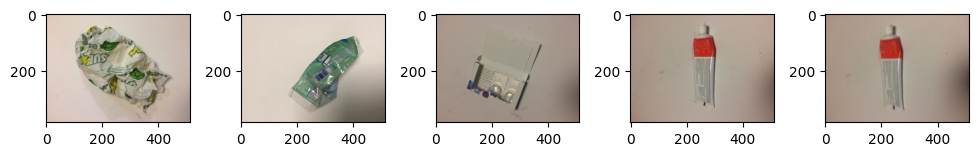

In [43]:
plot_imgs(veri_yolu+'/trash')


Bir batch size belirleyerek bu değeri batch_size değişkenine atarız.

In [44]:
batch_size = 32

Train verilerini ImageDataGenerator() fonksiyonu ile gerekli değişkenleri kullanarak (horizantal_flip, vertical_flip, validation_split , rescale , shear_range , zoom range , width_shift_range, height_shift_rain) train değişkenine kaydederiz.

In [46]:
train=ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

Test verilerini ImageDataGenerator() fonksiyonu ile gerekli parametreleri kullanarak (rescale, validation_split) test değişkeni içerisi içerisine kaydederiz.

In [47]:
test=ImageDataGenerator(rescale=1./255,validation_split=0.1)

train ve test değerlerini "train.flow_from_directory()" "test.flow_from_directory()" fonskiyonlarını uygun parametrelerle kullanarak tanımlanırız ve sırasıyla train_generator , test_generator değişkenlerinine atarız

In [ ]:
train_generator=train.flow_from_directory(veri_yolu,target_size=(512,384),batch_size=batch_size,class_mode='categorical',subset='training')

test_generator=test.flow_from_directory(veri_yolu,target_size=(512,384),batch_size=batch_size,class_mode='categorical',subset='validation')

Sonrasında verilerin daha kolay okunması için bir etiketleme yapılması gerekmektedir. Bu işlemi alt kısımda bulunan kod ile gerçekleştirebiliriz.

In [29]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


Kaç adet class'ımızın olduğunu num_classes değişkeni içerisine kaydetmemiz gerekmektedir. (Üst kısımda bu claslar ifade edilmiştir.)

In [30]:
num_classes = 6

Modelimizi artık inşa edebiliriz. Bu modeli istediğiniz şekilde build edebilirsiniz ancak örnek olması amacıyla şu şekilde bir yapı oluşturulabilir:

- Modeli Sequential olarak tanımla
- Conv2D katmanı
- MaxPooling2D katmanı
- Conv2D katmanı
- MaxPooling2D katmanı
- Conv2D katmanı
- MaxPooling2D katmanı
- Flatten Katmanı
- Dense Katmanı
- Dropout Katmanı
- Dens Katmanı

Ve son olarak bu katmanın model.summary() kullanarak şeklini yazdırabiliriz

In [31]:
# Build Model
model = Sequential()
   
model.add(Conv2D(32,(3,3), padding='same', input_shape=(512,384,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 384, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 192, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 192, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 96, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 96, 32)       18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 48, 32)       0

2022-12-20 21:49:17.402542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


------
Modeli model.compile() compile edebiliriz. Bu fonsiyon parametre olarak "loss, optimizer ve metrics" almaktadır

In [49]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Modelin çıktı vericeği modelin çıktı ismini model_path değişkeni içerisine kaydedebiliriz. .h5 formatı veya .model dosya formatı kullanılabilir.  

In [50]:
model_path="garbage_cnn.h5"
#checkpoint1 = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint1]

Yapay Zekanın kaç çevrimde çalışacağını yanı epoch sayısını girmemiz gerekmektedir. Bu sayıyı belirledikten sonra num_epochs değişkeni içerisinde kaydederek fit etmeye hazır hale getirebiliriz.

In [58]:
num_epochs = 1

Her bir epoch'ta ne kadar step atacağını alt kısımda belirlenen kod ile belirleyebiliriz. Bu sayıda değişiklik yapabilirsiniz.

In [59]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size

Modelimiz eğitime hazırdır. model.fit_generator() fonksiyonu uygun ve seçtiğimiz parametreler ile İstediğimiz isimle değişkene kaydedenbiliriz. Bu kod çalışınca modelimiz uzun bir eğitim sürecine girecektir.

In [60]:
history = model.fit_generator(train_generator, epochs=num_epochs, steps_per_epoch=step_size_train,validation_data=test_generator,
                    validation_steps=step_size_test)#,callbacks=callbacks_list)

/var/folders/0p/sxrbldkx7f7653ppf37_k2xw0000gn/T/ipykernel_51753/2559540315.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=num_epochs, steps_per_epoch=step_size_train,validation_data=test_generator,


71/71 [==============================] - 321s 5s/step - loss: 1.7678 - accuracy: 0.2170 - val_loss: 1.7248 - val_accuracy: 0.2188


-------
Modelimiz istediğimiz kadar katmanlı ve epochlu şekilde çalıştıktan sonra bu modelin ne kadar verimli olduğunu ölçmek için değerlendirmemiz gerekmektedir. Bu işlem için model.evaluate_generator() fonksiyonu uygun parametreler ile kullanılabilir. Sonrasında bu veri ekrana yazdırılır.

In [61]:
score = model.evaluate_generator(test_generator, steps=step_size_test)
print(score)

/var/folders/0p/sxrbldkx7f7653ppf37_k2xw0000gn/T/ipykernel_51753/986171445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator, steps=step_size_test)


[1.7188377380371094, 0.21875]


Son olarak da alt Kısımda bulunan kod ile histogram eğrilerimizi ekrana gösterebiliriz.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


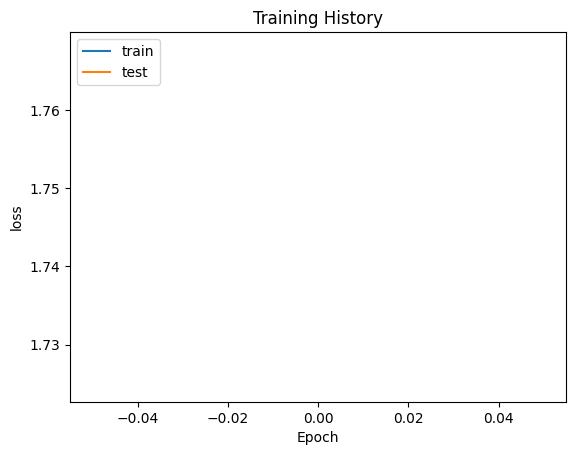

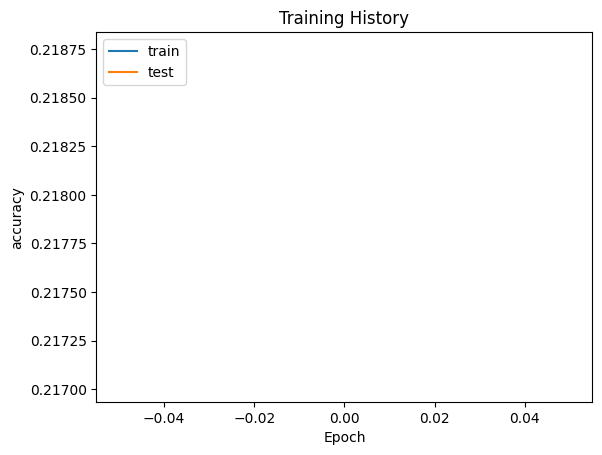

In [62]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')